Used to generate Injected feature files

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
data = np.loadtxt("../Training/simulation/injection/injection.txt", delimiter=",",dtype=str)
data

array([['10000198', '0', '0.020139', '1.855512', '0.803056144.823149'],
       ['10000198', '1', '0.113809', '14.793140', '0.845054306.327017'],
       ['10000198', '2', '0.064718', '8.840684', '0.225823359.938231'],
       ..., 
       ['9999901', '13', '0.080591', '1.771890', '0.3623951338.603838'],
       ['9999901', '14', '0.034998', '5.133518', '0.7657581467.734110'],
       ['9999901', '15', '0.066202', '1.252430', '0.6986601531.038299']], 
      dtype='|S19')

In [3]:
print data[:, 0:2],
#data_names = np.concatenate([str(data[:, 0]), str(data[:, 1])])
#print data_names

data_names =  np.core.defchararray.add(data[:,0] , "-")
data_names = np.core.defchararray.add(data_names, data[:,1])
data_names = np.core.defchararray.add(data_names, "_inj.blsanal")

print data_names.shape

for name in data_names:
    print name[:-8]
    break


[['10000198' '0']
 ['10000198' '1']
 ['10000198' '2']
 ..., 
 ['9999901' '13']
 ['9999901' '14']
 ['9999901' '15']] (195963,)
10000198-0_inj


In [4]:
#for name in data_names[20000:20100]
name = "10000198-1_inj.blsanal"
first_bls = np.loadtxt("../Training/simulation/injection/" + name)[0, 1:]
first_lc = np.loadtxt("../Training/simulation/injection/10000198-1_inj.txt")

[  14.83210813  306.30211693]
4.095535724e-05 0.999896370747
0.01017
0.00834 0.0002172987


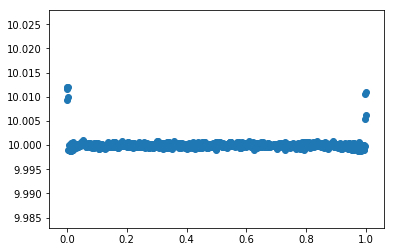

In [5]:
#plt.scatter(first_lc[:,0], first_lc[:,1])
print first_bls[0:2]
#print first_lc.shape
#fold it in phase space
phase = ((first_lc[:,0] -first_bls[1])/first_bls[0])%1
print phase.min(), phase.max()
plt.figure()
plt.scatter(phase, first_lc[:,1])
depth = first_bls[5]
print depth
transit_duration = first_bls[6]
ingress_duration = first_bls[7]*first_bls[6]*1.5
print transit_duration, ingress_duration

In [6]:
white_noise = np.std(first_lc[:,1][(phase>transit_duration/2) & (phase<1-transit_duration/2)])
mean_out_transit_flux = np.mean(first_lc[:,1][(phase>transit_duration/2) & (phase<1-transit_duration/2)])
#remove in transit portion
print white_noise

cleaned_vals = np.empty(shape=[0,3])
#remove transit signal
slope = depth /ingress_duration

for i, vals in enumerate(first_lc):
    vals =vals.reshape(1,3)
    #vals = time, flux, error?
    if phase[i] <transit_duration-ingress_duration or phase[i]>1-transit_duration+ingress_duration:
        vals[0][1] = vals[0][1]-depth
        
    elif ((phase[i] > transit_duration-ingress_duration  and phase[i]<transit_duration)) : 
        vals[0][1] -= (ingress_duration - phase[i]) *slope #vals[0][1]-depth

    elif ((phase[i]>1-transit_duration) and (phase[i]<1-transit_duration+ingress_duration)):
            
        vals[0][1] -= (ingress_duration - (1 - phase[i])) *slope #vals[0][1]-depth

    cleaned_vals = np.append(cleaned_vals, vals, axis = 0)

0.000358540095417


[]
0.99166 0.9918772987


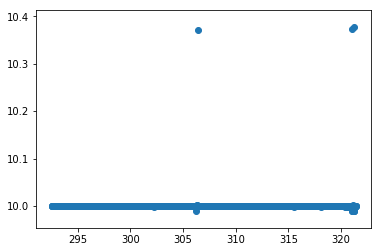

In [7]:
plt.scatter(cleaned_vals[:,0], cleaned_vals[:,1])
location = np.where(cleaned_vals[:,1]>10.5)
cleaned_vals[location,0]
print phase[location]
print 1 - transit_duration, 1 - transit_duration+ingress_duration

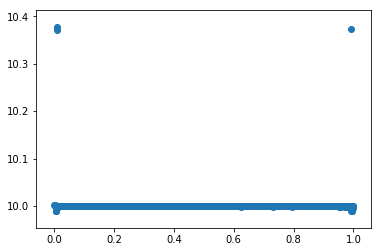

In [8]:
plt.scatter(phase, cleaned_vals[:,1])


In [9]:
#using transit width, search through phase space to find secondary and tertiary signals
comb = zip(phase, cleaned_vals[:,1]) 
comb.sort()
phase_time, total_flux = zip(*comb)
total_flux = np.asarray(total_flux).reshape((1303,1))

mod_sig_sec_dv = 0
mod_sig_pos_dv = 0
sec_loc = 0
phase_time = np.asarray(phase_time)

cut_phase =  phase_time[(phase_time > transit_duration) & (phase_time<(1-transit_duration))]
cut_flux = total_flux[(phase_time > transit_duration) & (phase_time<(1-transit_duration))]

for i, vals in enumerate(cut_phase):
    section = cut_flux[(cut_phase>cut_phase[i]) & (cut_phase<cut_phase[i]+transit_duration*2)]
    depth_two = np.mean(section) - mean_out_transit_flux
    if depth_two == max( mod_sig_sec_dv, depth_two):
        sec_loc = phase_time[i]
    mod_sig_sec_dv = max(mod_sig_sec_dv, depth_two)
    mod_sig_pos_dv = min(mod_sig_pos_dv, depth_two) 


/home/xuhuang/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/xuhuang/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


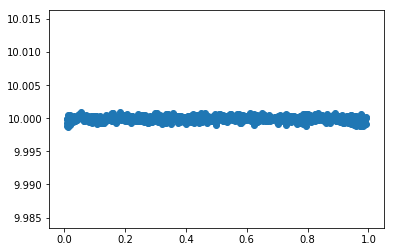

In [10]:
#find tertiary transit 
#remove signal where the secondary transit was found
plt.scatter(cut_phase, cut_flux)
#just subtract the mean signal from the secondary dip when cleanign for the third

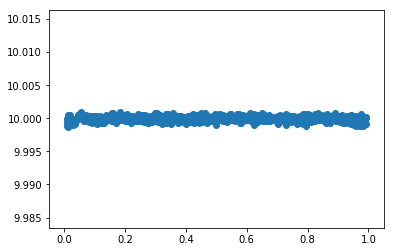

In [11]:
for i, vals in enumerate(cut_phase):
    if (vals< sec_loc+transit_duration) and (vals>sec_loc-transit_duration):
        #print  cut_flux[i], mod_sig_sec_dv
        cut_flux[i] -= mod_sig_sec_dv
        #print cut_flux[i]
plt.scatter(cut_phase, cut_flux)

#now repeat search for tertiary signal


In [12]:
mod_sig_ter_dv = 0
for i, vals in enumerate(cut_phase):
    section = cut_flux[(cut_phase>cut_phase[i]) & (cut_phase<cut_phase[i]+transit_duration*2)]
    sig = np.mean(section) - mean_out_transit_flux
    mod_sig_ter_dv = max(mod_sig_sec_dv, sig)
    
    
mod_sig_sec_dv = mod_sig_sec_dv - mean_out_transit_flux
print mod_sig_ter_dv, mean_out_transit_flux


0.000418657614379 9.9999643627


In [13]:
#red noise
#red noise^2 = white noise /npoiint + red noise
#inverse relationship
#try with three timescales, one, two, and threee t durations
#look at portions outside of transit?
red_noise_1 = []
red_noise_2 = []
red_noise_3 = []

red_noise_1_p = []
red_noise_2_p = []
red_noise_3_p = []

for i, vals in enumerate(cut_phase[:-1]):
    section1 = cut_flux[(cut_phase>cut_phase[i]) & (cut_phase<cut_phase[i]+transit_duration)]
    section2 = cut_flux[(cut_phase>cut_phase[i]) & (cut_phase<cut_phase[i]+transit_duration*2)]
    section3 = cut_flux[(cut_phase>cut_phase[i]) & (cut_phase<cut_phase[i]+transit_duration*3)]
    red_noise_1_p.append(section1.shape[0])
    red_noise_2_p.append(section2.shape[0])
    red_noise_3_p.append(section3.shape[0])
    red_noise_1.append(np.var(section1))
    red_noise_2.append(np.var(section2))
    red_noise_3.append(np.var(section3))
    
N_p_1 = np.median(red_noise_1_p)
N_p_2 = np.median(red_noise_2_p)
N_p_3 = np.median(red_noise_3_p)

In [21]:
# need only two values, and then solve
# use one and two timescales
white_noise_2 = (np.mean(red_noise_1) - np.mean(red_noise_2))* (N_p_1 * N_p_2) / (N_p_1+N_p_2)
print white_noise_2
red_noise = np.sqrt(np.mean(red_noise_1) - white_noise_2/N_p_1)
print red_noise, white_noise, white_noise_2
print "Red noise", first_bls[17]
# use first white nosie

-7.03479633257e-08
0.000317627426959 0.000358540095417 -7.03479633257e-08
REd noise 0.00019


In [15]:
#modshi


NameError: name 'modshi' is not defined

In [16]:
from scipy.special import erfcinv

period = first_bls[0]
n_trans = first_bls[14]

print n_trans
mod_sig_pri_dv = depth
mod_fred_dv = red_noise / white_noise # ratio between the two
mod_fa1_dv = np.sqrt(2) * erfcinv(transit_duration/(period* n_trans))
mod_fa2_dv = np.sqrt(2) * erfcinv(transit_duration/(period))

modshiftval1_dv = mod_sig_pri_dv/mod_fred_dv - mod_fa1_dv
modshiftval2_dv = mod_sig_pri_dv - mod_sig_ter_dv-mod_fa2_dv
modshiftval3_dv = mod_sig_pri_dv - mod_sig_pos_dv - mod_fa2_dv
modshiftval4_dv = mod_sig_sec_dv / mod_fred_dv - mod_fa1_dv
modshiftval5_dv = mod_sig_sec_dv - mod_sig_ter_dv - mod_fa2_dv
modshiftval6_dv = mod_sig_sec_dv-mod_sig_pos_dv - mod_fa2_dv

print mod_sig_pri_dv, mod_fred_dv, mod_fa1_dv
print modshiftval1_dv, modshiftval2_dv, modshiftval3_dv
print modshiftval4_dv, modshiftval5_dv, modshiftval6_dv

vals = [mod_sig_pri_dv, mod_sig_sec_dv, mod_sig_ter_dv, mod_sig_pos_dv, mod_fa1_dv, mod_fa2_dv,
       mod_fred_dv, modshiftval1_dv, modshiftval2_dv, modshiftval3_dv, modshiftval4_dv,
       modshiftval5_dv, modshiftval6_dv, white_noise, red_noise]

total_Vals = np.concatenate([vals, first_bls])
print total_Vals.shape
head_txt = """mod_sig_pri_dv mod_sig_sec_dv mod_sig_ter_dv mod_sig_pos_dv mod_fa1_dv mod_fa2_dv mod_fred_dv modshiftval1_dv modshiftval2_dv modshiftval3_dv modshiftval4_dv modshiftval5_dv modshiftval6_dv white_noise red_noise BLS_Period_1_0 BLS_Tc_1_0 BLS_SN_1_0 BLS_SR_1_0 BLS_SDE_1_0 BLS_Depth_1_0 BLS_Qtran_1_0 BLS_Qingress_1_0 BLS_OOTmag_1_0 BLS_i1_1_0 BLS_i2_1_0 BLS_deltaChi2_1_0 BLS_fraconenight_1_0 BLS_Npointsintransit_1_0 BLS_Ntransits_1_0 BLS_Npointsbeforetransit_1_0 BLS_Npointsaftertransit_1_0 BLS_Rednoise_1_0 BLS_Whitenoise_1_0 BLS_SignaltoPinknoise_1_0 """
np.savetxt("InjModShiftVals/" + name +"_feats.txt", total_Vals, header=head_txt)


print first_bls

2.0
0.01017 0.885890953395 3.63207918364
-3.62059921541 -3.43942775017 -3.43843327467
-14.9196373947 -13.4491434553 -13.4481489798
(35,)
[  1.48321081e+01   3.06302117e+02   9.30173000e+00   7.30000000e-04
   8.49247000e+00   1.01700000e-02   8.34000000e-03   1.73700000e-02
   1.00000600e+01   9.21690000e-01   9.30030000e-01  -7.00000000e-04
   6.00390000e-01   9.00000000e+00   2.00000000e+00   1.00000000e+01
   1.10000000e+01   1.90000000e-04   3.80000000e-04   5.51557100e+01]
